# Reading the data

In [1]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from gurobipy import *
import cvxopt
import cvxpy as cvx
from  scipy.io import savemat, loadmat

# scikit learn
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import svm
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matlab.engine

In [2]:
eng = matlab.engine.start_matlab()

In [7]:
# reading CSV file
reader = csv.reader(open('features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open('all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [8]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

Protein names equality check: True


In [5]:
print X.shape

(8513L, 165L)


# Feature selection

## Counting importances of the features and correlation matrix

In [6]:
n = 165
eng = matlab.engine.start_matlab()
scores_mtl = np.zeros(shape=(n, 12))
for i in range(n):
    arr = i
    savemat('fs.mat', mdict={'arr': arr})
    scores_mtl[i] = np.array(eng.main())

In [7]:
savemat('costs.mat', mdict={'costs': scores_mtl})
costs = np.min(scores_mtl, axis = 1)
print costs

[ 0.4704476   0.45696177  0.47519244  0.45988408  0.47952589  0.47874017
  0.45167645  0.43315963  0.48441655  0.43811154  0.4821809   0.48629579
  0.45575199  0.48225098  0.48668526  0.45999716  0.48105096  0.48456062
  0.47578903  0.48117834  0.46671217  0.48674617  0.46258746  0.44136885
  0.468677    0.48542814  0.44644459  0.45004591  0.47415847  0.46373973
  0.4726673   0.47213372  0.45628585  0.48238768  0.48771423  0.49016435
  0.46993127  0.46793019  0.45752324  0.45161533  0.48222413  0.48211823
  0.45702874  0.44132989  0.48384723  0.46275156  0.47869367  0.49150431
  0.44004204  0.48579458  0.46985944  0.47892566  0.47642831  0.46756422
  0.47599233  0.45467885  0.47156138  0.44836301  0.48272762  0.47721789
  0.46969075  0.46931482  0.47545179  0.4615827   0.484907    0.47416703
  0.47863915  0.48386989  0.47181416  0.49147889  0.4741569   0.46288851
  0.46960171  0.47830961  0.45705093  0.48828746  0.4545579   0.47784068
  0.45995112  0.48343395  0.45880119  0.47957908  0

In [10]:
data_norm = preprocessing.scale(X)
e = np.corrcoef(data_norm.T)
w = costs

## Greedy algorithm with importances

In [13]:
def select_features(t, e):
    global costs
    S = []
    c = 0.1
    ind = range(n)
    opt = []
    w = np.copy(costs)
    for i in range(t):
        f = np.argmax(w)
        w[f] = -np.inf
        for j in range(n):
            w[j] = w[j] - e[f, j]*2*c
        opt.append(ind[f])
    return opt

In [30]:
eng = matlab.engine.start_matlab()
auc_greedy_mean = []
auc_greedy_min = []
scores = np.zeros(shape=(n, 12))
for t in range(1, 160):
    opt = select_features(t, e)
    X_new = data_norm[:, opt]
    savemat('fs.mat', mdict={'arr': opt})
    scores[t] = np.array(eng.main())
    auc_greedy_mean.append(scores.mean()) 
    auc_greedy_min.append(np.min(scores)) 

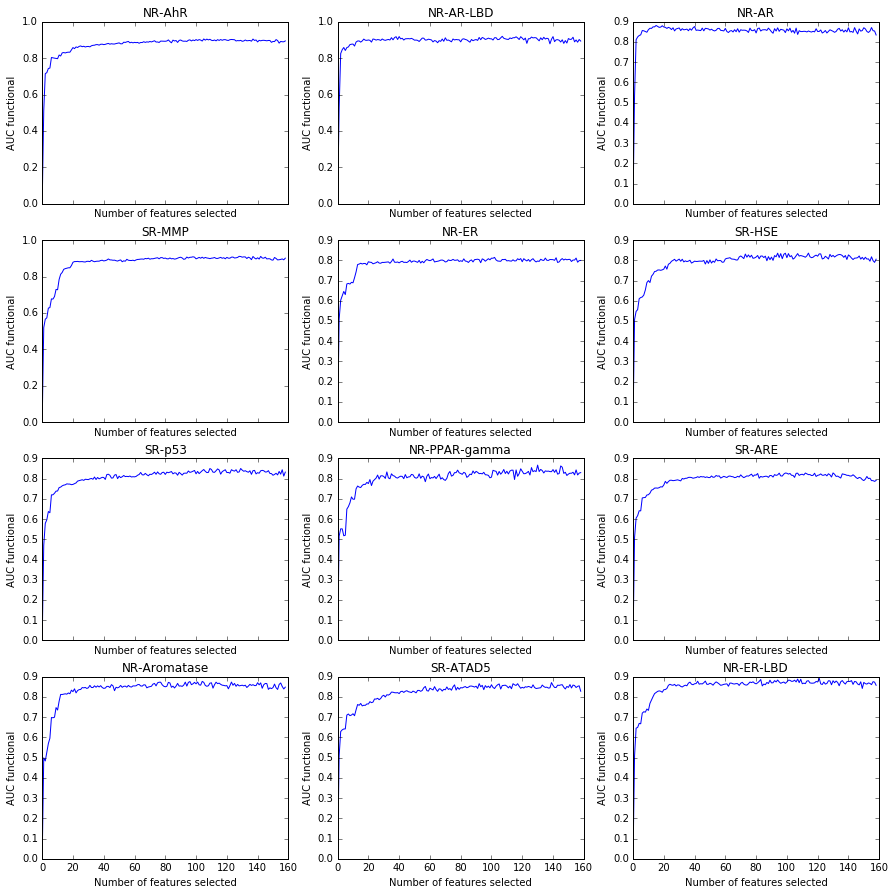

In [10]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(4, 3, sharex=True, figsize=(15,15))
for i in range(12):
    k = i/3
    l = i - k*3
    axes[k, l].plot(scores[0:159, i])
    axes[k, l].set_title(receptor_names[i])
    axes[k, l].set_xlabel('Number of features selected')
    axes[k, l].set_ylabel('AUC functional')
plt.show()
savemat('40neurons_res.mat', mdict={'scores': scores})

In [42]:
print feature_names[opt]

['SlogP_VSA8' 'BCUT_PEOE_0' 'BCUT_PEOE_3' 'BCUT_SMR_0' 'SMR_VSA6'
 'PEOE_PC-' 'PEOE_PC+' 'opr_leadlike' 'opr_violation' 'PEOE_RPC-'
 'GCUT_PEOE_3' 'VAdjEq' 'b_ar' 'SMR_VSA7' 'PEOE_VSA_FPOL' 'PEOE_VSA_FHYD'
 'PEOE_VSA_FPPOS' 'lip_druglike' 'lip_don' 'SlogP' 'logS' 'SMR_VSA5'
 'BCUT_SMR_1' 'BCUT_PEOE_2' 'BCUT_SLOGP_1' 'GCUT_PEOE_2' 'PEOE_VSA-3'
 'BCUT_PEOE_1' 'BCUT_SLOGP_2' 'PEOE_VSA_FPOS' 'PEOE_VSA_FNEG' 'SlogP_VSA2'
 'PEOE_VSA-2' 'PEOE_RPC+' 'SlogP_VSA5' 'SlogP_VSA4' 'GCUT_PEOE_1'
 'PEOE_VSA_FPNEG' 'SlogP_VSA7' 'b_1rotR' 'PEOE_VSA+2' 'GCUT_SLOGP_0'
 'vsa_don' 'BCUT_SMR_3' 'BCUT_SLOGP_0' 'balabanJ' 'opr_nring' 'a_acid'
 'a_nBr' 'b_triple' 'a_nB' 'a_nI' 'SMR_VSA4' 'FCharge' 'BCUT_SLOGP_3'
 'GCUT_SMR_0' 'b_rotR' 'SlogP_VSA6' 'vsa_base' 'PEOE_VSA+4' 'GCUT_SLOGP_1'
 'PEOE_VSA-4' 'reactive' 'BCUT_SMR_2' 'SlogP_VSA3' 'GCUT_PEOE_0'
 'PEOE_VSA+0' 'PEOE_VSA+3' 'GCUT_SMR_1' 'a_aro' 'SlogP_VSA0' 'a_nP' 'a_nF'
 'PEOE_VSA+5' 'a_nS' 'vsa_acid' 'PEOE_VSA+6' 'PEOE_VSA-1' 'PEOE_VSA-0'
 'SMR_VSA2' 'a_nCl

In [40]:
for i in range(12):
    print receptor_names[i], np.max(scores[:, i]), np.argmax(scores[:, i])

NR-AhR 0.905689101908 105
NR-AR-LBD 0.920141650374 107
NR-AR 0.881872253114 15
SR-MMP 0.910911869778 128
NR-ER 0.814609674651 102
SR-HSE 0.835912098994 114
SR-p53 0.850537801685 129
NR-PPAR-gamma 0.86723978648 130
SR-ARE 0.828669479885 130
NR-Aromatase 0.877511759197 104
SR-ATAD5 0.871725032724 139
NR-ER-LBD 0.893220178583 121


## Solving the problem with cvxpy non integer solver

In [14]:
eng = matlab.engine.start_matlab()
auc2 = []
er2 = []
er22 = []
scores_cvxpy = np.zeros(shape = (160, 12))
for k in range(1,160):
    e = np.abs(np.corrcoef(data_norm.T))
    np.fill_diagonal(e, 0)
    e = e.dot(e.T)
    w = 5*n*costs
    x = cvx.Variable(n)
    obj = cvx.Maximize(w*x + cvx.quad_form(x, -e))
    constraints = [x >= 0, x<= 1, sum(x) == k]
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    ans = np.array([np.array(x.value) > 0.2]).reshape(n)
    savemat('fs.mat', mdict={'arr': np.nonzero(ans)})
    scores_cvxpy[k] = np.array(eng.main())
    auc2.append(scores_cvxpy.mean())
    er2.append(prob.value)
    er22.append(np.inner(w, ans) - e.dot(ans).T.dot(ans))
    

In [17]:
for i in range(12):
    print receptor_names[i], np.max(scores_cvxpy[:, i]), np.argmax(scores_cvxpy[:, i]) 

 NR-AhR 0.905524183111 134
NR-AR-LBD 0.923434343036 97
NR-AR 0.875582805302 156
SR-MMP 0.910840815855 103
NR-ER 0.812386807651 133
SR-HSE 0.837220593083 124
SR-p53 0.857072845256 155
NR-PPAR-gamma 0.857124186417 105
SR-ARE 0.830329168537 103
NR-Aromatase 0.877587456292 123
SR-ATAD5 0.875304475658 101
NR-ER-LBD 0.893154261298 88


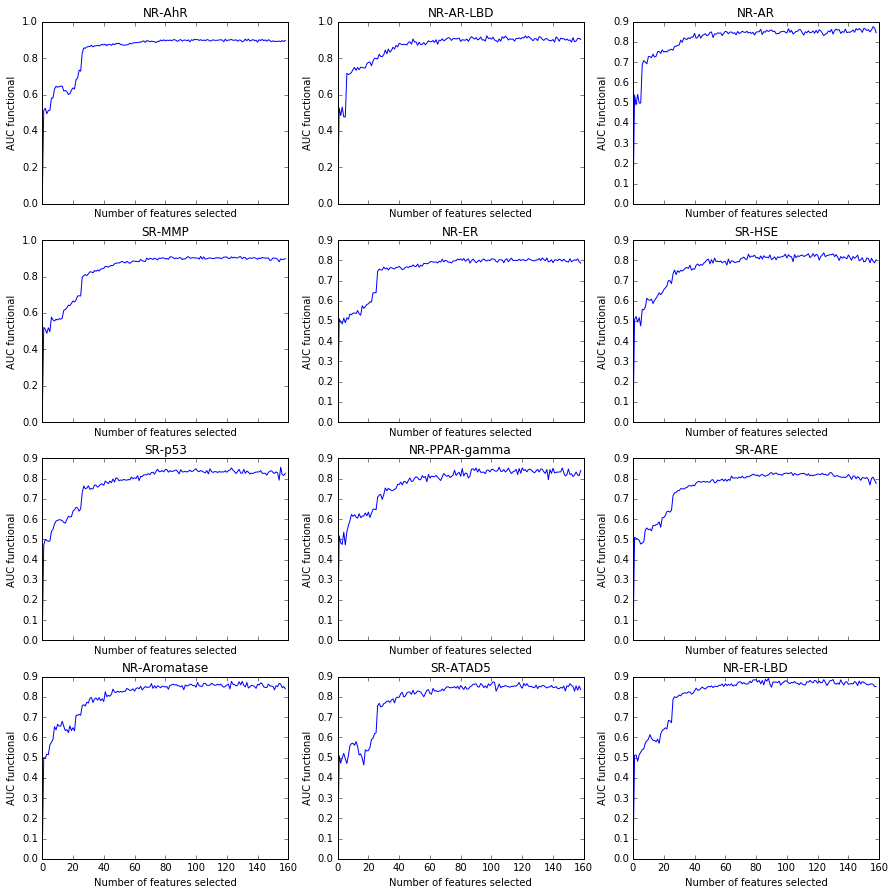

In [32]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(4, 3, sharex=True, figsize=(15,15))
for i in range(12):
    k = i/3
    l = i - k*3
    axes[k, l].plot(scores_cvxpy[0:159, i])
    axes[k, l].set_title(receptor_names[i])
    axes[k, l].set_xlabel('Number of features selected')
    axes[k, l].set_ylabel('AUC functional')
plt.show()
savemat('40neurons_res_cvxpy.mat', mdict={'scores': scores_cvxpy})

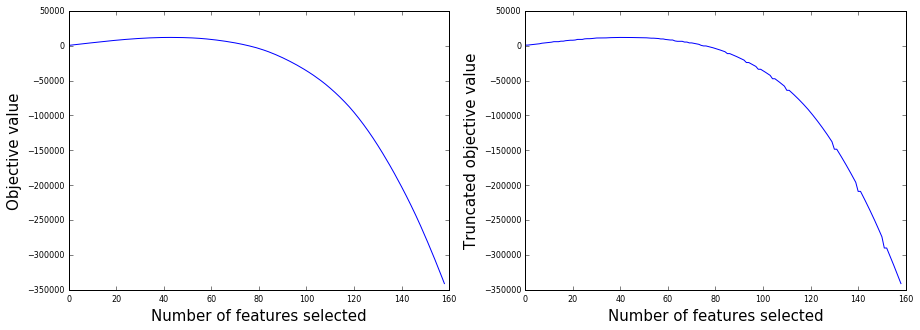

In [28]:
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlabel('Number of features selected',  fontsize=15)
axes[0].set_ylabel('Objective value',  fontsize=15)
axes[0].plot(er2)
axes[1].set_xlabel('Number of features selected',  fontsize=15,)
axes[1].set_ylabel('Truncated objective value',  fontsize=15)
axes[1].plot(er22)
plt.show()

## Solving the problem with gurobi integer solver

In [20]:
auc3 = []
er3 = []
eng = matlab.engine.start_matlab()
scores_gurobi = np.zeros(shape = (160, 12))
for k in range(1,160):
    e = np.abs(np.corrcoef(data_norm.T))
    np.fill_diagonal(e, 0)
    e = e.dot(e.T)
    w = 5*n*costs
    x = cvx.Bool(n)
    obj = cvx.Maximize(w*x + cvx.quad_form(x, -e))
    constraints = [x >= 0, x<= 1, sum(x) == k]
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver = 'GUROBI')
    ans = np.array(x.value, dtype = 'bool').reshape(n)
    savemat('fs.mat', mdict={'arr': np.nonzero(ans)})
    scores_gurobi[k] = np.array(eng.main())
    auc3.append(scores_gurobi[k].mean())
    er3.append(prob.value)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

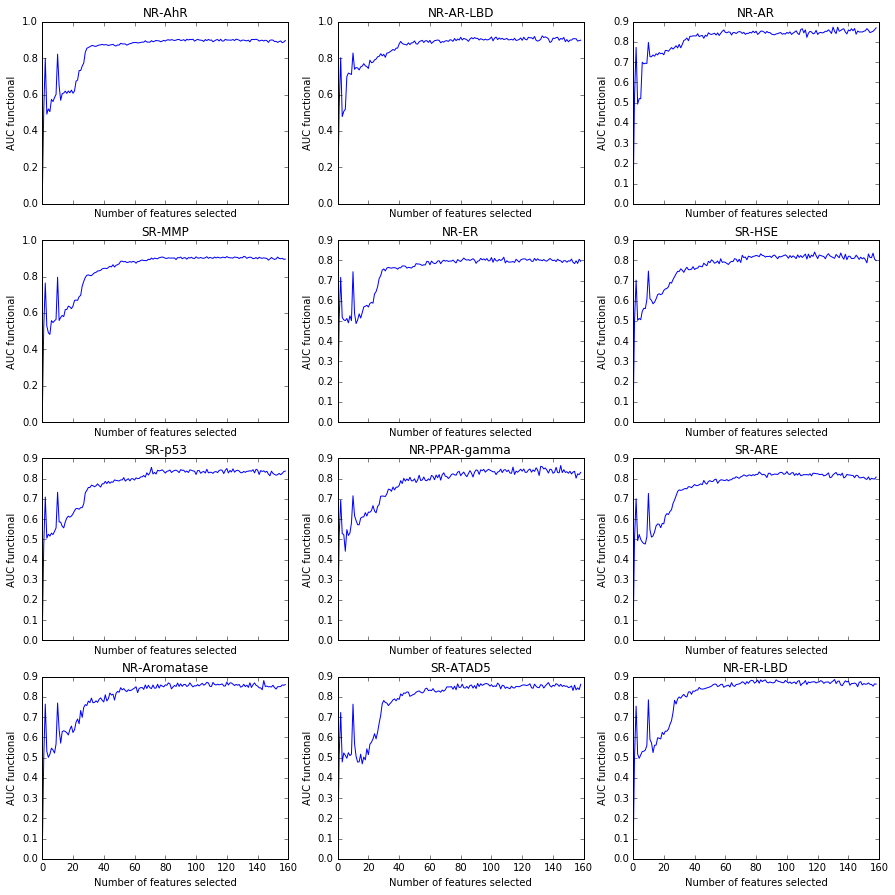

In [31]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(4, 3, sharex=True, figsize=(15,15))
for i in range(12):
    k = i/3
    l = i - k*3
    axes[k, l].plot(scores_gurobi[0:159, i])
    axes[k, l].set_title(receptor_names[i])
    axes[k, l].set_xlabel('Number of features selected')
    axes[k, l].set_ylabel('AUC functional')
plt.show()
savemat('40neurons_res_gurobi.mat', mdict={'scores': scores_gurobi})

In [22]:
for i in range(12):
    print receptor_names[i], np.max(scores_gurobi[:, i]), np.argmax(scores_gurobi[:, i]) 

NR-AhR 0.904937988999 126
NR-AR-LBD 0.922512498492 133
NR-AR 0.873753361245 130
SR-MMP 0.91096438225 131
NR-ER 0.815668118766 108
SR-HSE 0.841093977794 118
SR-p53 0.856333761002 71
NR-PPAR-gamma 0.865248743194 145
SR-ARE 0.835412745248 100
NR-Aromatase 0.881430757946 144
SR-ATAD5 0.871733231245 137
NR-ER-LBD 0.886719332548 131
